In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
from glob import glob
import sys
sys.path.append("/Odyssey/private/t22picar/tools")
#from plot_tools import plot_uv_map, plot_map_zoom_only
from jaxparrow import cyclogeostrophy, geostrophy

In [4]:
ssh_imt = "/Odyssey/public/UNET_rec_sla/4Dvar_unet_SSH_2010-01-01_2010-02-01_4th.nc"
ssh_imt = xr.open_dataset(ssh_imt)
ssh_imt

<xarray.Dataset> Size: 121MB
Dimensions:  (time: 31, lat: 680, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 248B 2010-01-01 2010-01-02 ... 2010-01-31
  * lat      (lat) float32 3kB -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * lon      (lon) float32 6kB -180.0 -179.7 -179.5 -179.2 ... 179.4 179.7 179.9
Data variables:
    zos      (time, lat, lon) float32 121MB ...

In [16]:
# Compute uvgeo from SSH
# Import necessary modules
import numpy
import xarray as xr
import sys
sys.path.append("/Odyssey/private/t22picar/tools")
from plot_tools import plot_uv_map, plot_map_zoom_only
from datetime import datetime, timedelta
from jaxparrow import cyclogeostrophy, geostrophy
from tqdm import tqdm  # Importer tqdm
#from IPython.display import clear_output

lat_mask=5
depth = "15m"

file_data = f"/Odyssey/private/t22picar/data/glorys_{depth}/glorys_multivar_{depth}_2010-2018.nc"
maps_4th = xr.open_dataset(file_data)
#maps=maps.sel(time="2010-01-01")
lon_ref = maps_4th.lon.values
lat_ref = maps_4th.lat.values

ssh_imt = "/Odyssey/public/UNET_rec_sla/4Dvar_unet_SSH_2010-01-01_2010-02-01_4th.nc"
ssh_imt = xr.open_dataset(ssh_imt)
#ssh_imt

# Get longitudes and latitudes
lon = ssh_imt.lon.values
lat = ssh_imt.lat.values
lon2D, lat2D = numpy.meshgrid(lon, lat)

start_date = datetime(2010, 1, 1)
end_date = datetime(2010, 1, 10)
current_date = start_date
time_index=0
ugeo_list=[]
vgeo_list=[]
uageo_list=[]
vageo_list=[]
time_list=[]

# Initialiser la barre de progression
total_iterations = ssh_imt.time.values.shape[0]
pbar = tqdm(total=total_iterations, desc="Ajout des pas de temps")

while current_date < end_date:
    print(current_date)
    ssh_imt
    map = ssh_imt.sel(time=current_date)
    #Compute geostrophy
    (u_geo,v_geo,lat_u, lon_u, lat_v, lon_v) = geostrophy(map.zos.values, lat2D, lon2D)

    # Créer un DataArray pour "u"
    u_geo_xr = xr.DataArray(
        u_geo,
        dims=("lat", "lon"),
        coords={

            "lat": lat_u[:,0],
            "lon": lon_u[0,:],
        },
        name="ugeo"
    ).expand_dims(time=[current_date])

    # Créer un DataArray pour "u"
    v_geo_xr = xr.DataArray(
        v_geo,
        dims=("lat", "lon"),
        coords={

            "lat": lat_u[:,0],
            "lon": lon_u[0,:],
        },
        name="vgeo"
    ).expand_dims(time=[current_date])

    #print("interp 4th ...")
    u_geo_xr = u_geo_xr.interp({"lat":lat_ref, "lon":lon_ref}, method="linear")
    v_geo_xr = v_geo_xr.interp({"lat":lat_ref, "lon":lon_ref}, method="linear")

    # Ajouter à la liste
    ugeo_list.append(u_geo_xr)
    vgeo_list.append(v_geo_xr)
    time_list.append(current_date)

    current_date += timedelta(days=1)
    time_index=time_index+1
    pbar.update(1)
    # Nettoyer le terminal
    #clear_output(wait=True)

# Fermer la barre de progression
pbar.close()

# Concaténer tous les DataArrays le long de la dimension "time"
ugeo = xr.concat(ugeo_list, dim="time")
vgeo = xr.concat(vgeo_list, dim="time")
# Créer le Dataset final
ds = xr.Dataset({"ugos": ugeo, "vgos": vgeo})


Ajout des pas de temps:   0%|          | 0/31 [00:00<?, ?it/s]

2010-01-01 00:00:00


Ajout des pas de temps:   3%|▎         | 1/31 [00:00<00:12,  2.42it/s]

2010-01-02 00:00:00


Ajout des pas de temps:   6%|▋         | 2/31 [00:00<00:11,  2.61it/s]

2010-01-03 00:00:00


Ajout des pas de temps:  10%|▉         | 3/31 [00:01<00:10,  2.64it/s]

2010-01-04 00:00:00


Ajout des pas de temps:  13%|█▎        | 4/31 [00:01<00:10,  2.58it/s]

2010-01-05 00:00:00


Ajout des pas de temps:  16%|█▌        | 5/31 [00:01<00:09,  2.62it/s]

2010-01-06 00:00:00


Ajout des pas de temps:  19%|█▉        | 6/31 [00:02<00:09,  2.58it/s]

2010-01-07 00:00:00


Ajout des pas de temps:  23%|██▎       | 7/31 [00:02<00:09,  2.62it/s]

2010-01-08 00:00:00


Ajout des pas de temps:  26%|██▌       | 8/31 [00:03<00:08,  2.63it/s]

2010-01-09 00:00:00


Ajout des pas de temps:  29%|██▉       | 9/31 [00:03<00:08,  2.63it/s]


In [17]:
ds

<xarray.Dataset> Size: 71MB
Dimensions:  (time: 9, lat: 680, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 72B 2010-01-01 2010-01-02 ... 2010-01-09
  * lat      (lat) float32 3kB -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * lon      (lon) float32 6kB -180.0 -179.7 -179.5 -179.2 ... 179.4 179.7 179.9
Data variables:
    ugos     (time, lat, lon) float32 35MB nan nan nan nan ... nan nan nan nan
    vgos     (time, lat, lon) float32 35MB nan nan nan nan ... nan nan nan nan

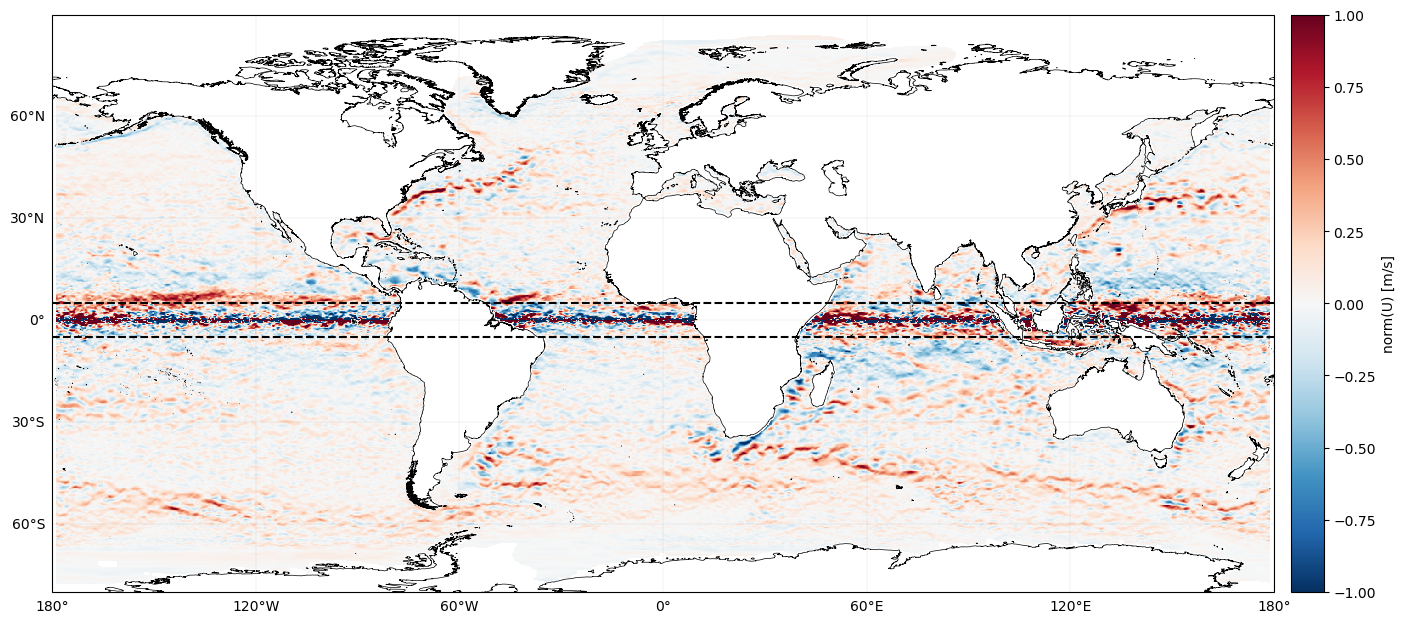

In [22]:
plot_uv_map(ds.ugos[0],ds.lon,ds.lat)

In [ ]:
""""""

print("Saving...")
save_file=f"/Odyssey/private/t22picar/data/glorys_{depth}/glorys_uv_geo_and_ageo_{depth}_2010-2018.nc"

# Sauvegarder le DataArray en fichier NetCDF
ds.to_netcdf(save_file)

In [ ]:
result_filepath = "/Odyssey/public/UNET_rec_sla/4Dvar_unet_SSH_2010-01-01_2010-02-01_4th.nc"
uvgos = xr.open_dataset(result_filepath).sel(time="2010-01-21")
#ssh_duacs = ssh_duacs.interp(lon=lon_u,lat=lat_u)
uvgos

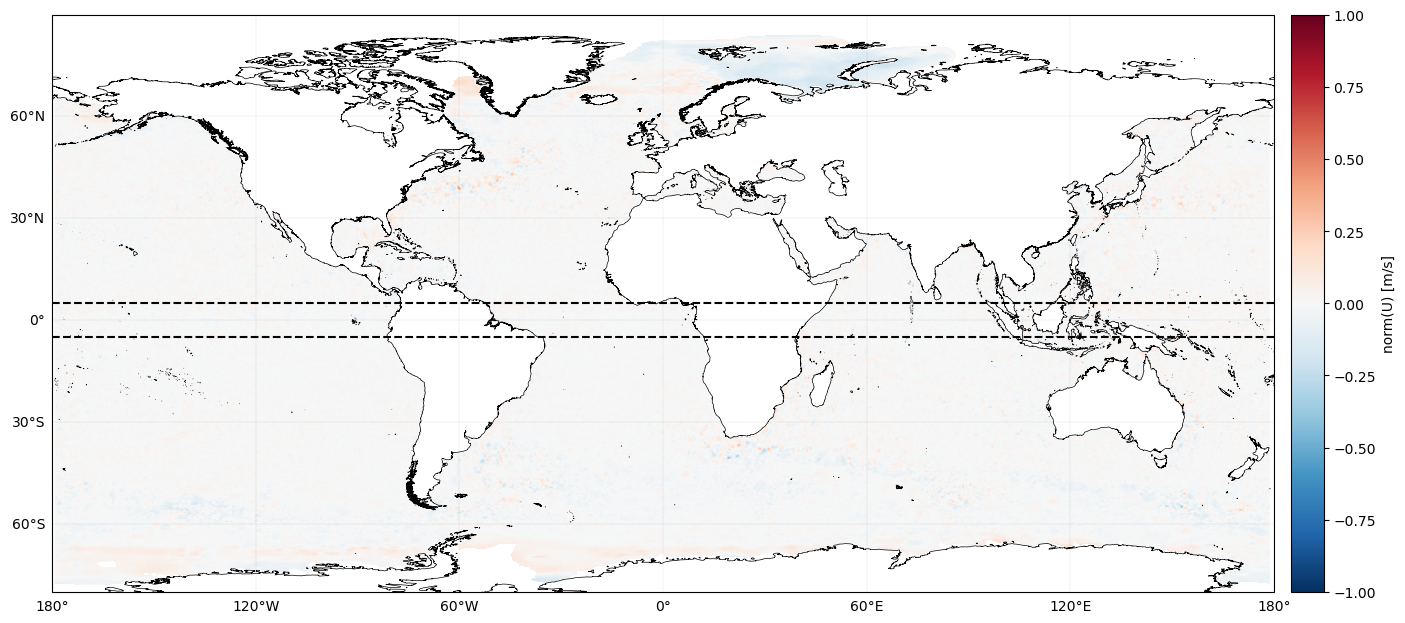

In [ ]:
plot_uv_map(uvgos.ugos,uvgos.lon,uvgos.lat)

In [ ]:

(u_geo,v_geo,lat_u, lon_u, lat_v, lon_v) = geostrophy(ssh, lat2D, lon2D)


In [ ]:
# Créer un DataArray pour "u"
u_geo_xr = xr.DataArray(
    u_geo,
    dims=("lat", "lon"),
    coords={

        "lat": lat_u[:,0],
        "lon": lon_u[0,:],
    },
    name="ugeo"
).expand_dims(time=[current_date])

# Créer un DataArray pour "u"
v_geo_xr = xr.DataArray(
    v_geo,
    dims=("lat", "lon"),
    coords={

        "lat": lat_u[:,0],
        "lon": lon_u[0,:],
    },
    name="vgeo"
).expand_dims(time=[current_date])

#print("Interpolation grille d'origine")
    # Interpolation grille d'origine
u_geo_xr_int = u_geo_xr.interp({"lat":lat_ref, "lon":lon_ref}, method="linear")
v_geo_xr_int = v_geo_xr.interp({"lat":lat_ref, "lon":lon_ref}, method="linear")

ugeo = xr.concat(ugeo_list, dim="time")
ugeo = xr.concat(ugeo_list, dim="time")

In [81]:
u_geo_xr_int

<xarray.DataArray 'ugeo' (time: 1, lat: 680, lon: 1440)> Size: 4MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2010-01-21
  * lat      (lat) float32 3kB -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * lon      (lon) float32 6kB -180.0 -179.7 -179.5 -179.2 ... 179.4 179.7 179.9

In [48]:
(u_cgeo,v_cgeo,lat_u, lon_u, lat_v, lon_v) = cyclogeostrophy(ssh, lat2D, lon2D)

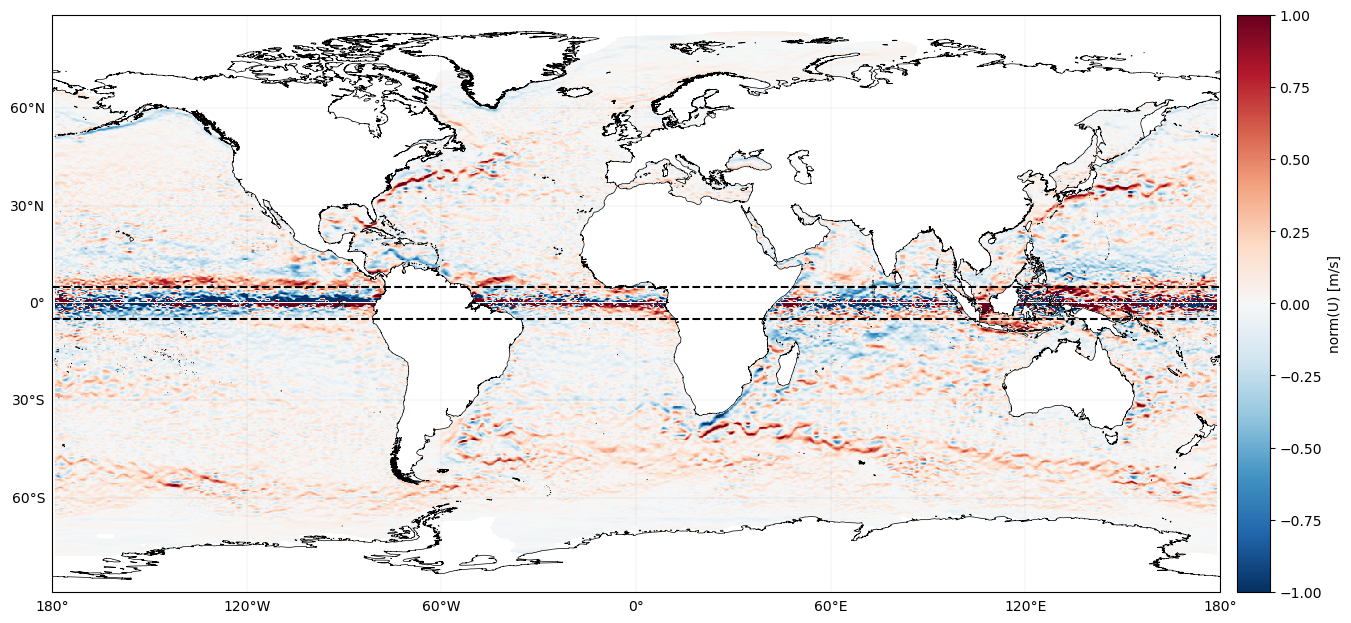

In [47]:
plot_uv_map(u_geo,lon_u,lat_u)

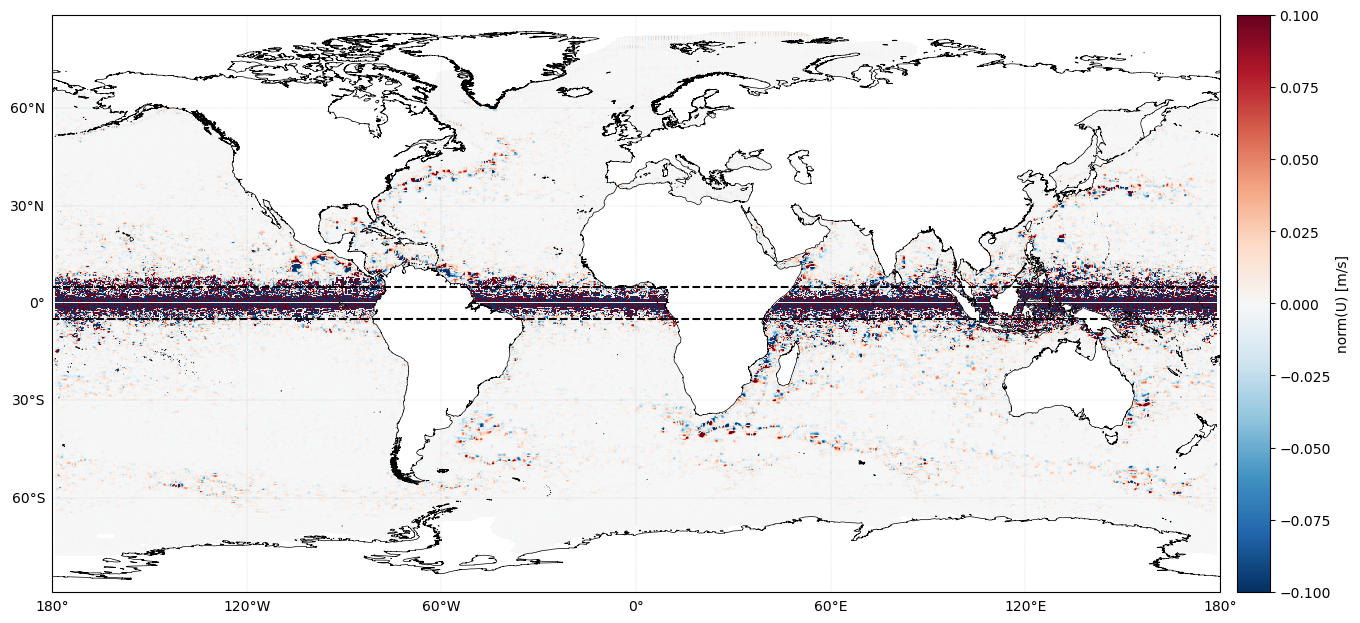

In [51]:
plot_uv_map(u_cgeo-u_geo,lon_u,lat_u,vmin=-0.1,vmax=0.1)

In [63]:
np.array(lon_u[0,:])

array([-178.875, -178.625, -178.375, ...,  178.375,  178.625,  179.   ],
      dtype=float32)

In [75]:
result_filepath = "/Odyssey/private/t22picar/data/ssh_L4/SSH_L4_CMEMS_2010-01-01-2024-01-01_4th.nc"
ssh_duacs = xr.open_dataset(result_filepath).sel(time="2010-01-21")
#ssh_duacs = ssh_duacs.interp(lon=lon_u,lat=lat_u)
ssh_duacs

<xarray.Dataset> Size: 16MB
Dimensions:  (lat: 680, lon: 1440)
Coordinates:
    time     datetime64[ns] 8B 2010-01-21
  * lat      (lat) float32 3kB -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * lon      (lon) float32 6kB -180.0 -179.7 -179.5 -179.2 ... 179.4 179.7 179.9
Data variables:
    zos      (lat, lon) float32 4MB ...
    sla      (lat, lon) float32 4MB ...
    ugos     (lat, lon) float32 4MB ...
    vgos     (lat, lon) float32 4MB ...
Attributes:
    references:                http://marine.copernicus.eu
    title:                     DT merged all satellites Global Ocean Gridded ...
    history:                   2024-10-23 12:55:06Z: Creation
    source:                    Altimetry measurements
    comment:                   Sea Surface Height measured by Altimetry and d...
    institution:               CLS, CNES
    contact:                   servicedesk.cmems@mercator-ocean.eu
    Conventions:               CF-1.6
    copernicusmarine_version:  2.0.1

In [76]:
ssh_duacs = ssh_duacs.interp(lon=np.array(lon_u[0,:]),lat=np.array(lat_u[:,0]))

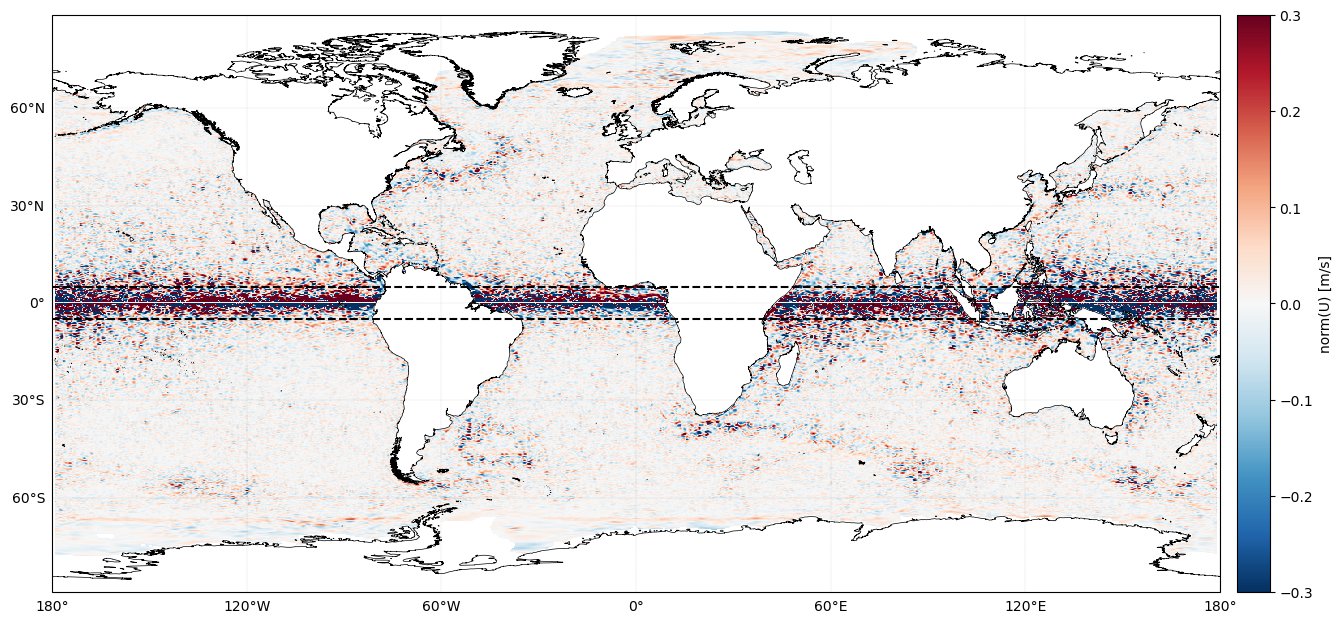

In [77]:
plot_uv_map(ssh_duacs.ugos-u_geo,lon_u,lat_u,vmin=-0.3,vmax=0.3)

In [ ]:

#ds = ds.transpose('time','lat','lon')

start_date = datetime(2010, 1, 1)
end_date = datetime(2010, 1, 3)

start_time= start_date.strftime("%Y-%m-%d")
end_time= end_date.strftime("%Y-%m-%d")

                                
file_out = "/Odyssey/public/NeurOST/"
str_save_file = f"NeurOST_{start_time}_{end_time}_{size_grid}.nc"

# Import reference grid 
map_4th = "/Odyssey/private/t22picar/data/glorys_15m/glorys_multivar_15m_2010-2018.nc"
map_4th = xr.open_dataset(map_4th).sel(time="2010-01-01")
lat_ref = map_4th.lat.values
lon_ref = map_4th.lon.values

map = maps.sel(time=slice(start_date,start_date))

ds = map.interp({"lat":lat_ref, "lon":lon_ref}, method="linear")
current_date = start_date + timedelta(days=1)

time_index=1
while current_date < end_date:
    map = maps.sel(time=current_date)
    map = map.interp({"lat":lat_ref, "lon":lon_ref}, method="linear")

    # Concaténation
    ds = xr.concat([ds, map], dim="time")
    current_date += timedelta(days=1)
# save data 

save_file=file_out+str_save_file
# Sauvegarder le DataArray en fichier NetCDF
ds.to_netcdf(save_file)

In [55]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd 
import sys 

sys.path.append("../../../tools")
from plot_tools import plot_uv_map,plot_map_zoom

In [56]:
ssh = xr.open_dataset(save_file)
ssh

<xarray.Dataset> Size: 31MB
Dimensions:                 (time: 2, lat: 680, lon: 1440)
Coordinates:
    Lambert_Azimuthal_Grid  int32 4B ...
  * time                    (time) datetime64[ns] 16B 2010-01-01 2010-01-02
  * lat                     (lat) float32 3kB -80.0 -79.75 -79.5 ... 89.75 90.0
  * lon                     (lon) float32 6kB -180.0 -179.7 ... 179.7 179.9
Data variables:
    adt                     (time, lat, lon) float32 8MB ...
    sla                     (time, lat, lon) float32 8MB ...
    ugos                    (time, lat, lon) float32 8MB ...
    vgos                    (time, lat, lon) float32 8MB ...
Attributes: (12/38)
    title:                      Daily NeurOST (SSH-SST) Sea Surface Height an...
    summary:                    A mapped level 4 sea surface height analysis ...
    Conventions:                CF-1.10
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    keywords:                   Oceans > Sea Surface Topography > Sea Surface...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    ...                         ...
    publisher_name:             JPL PO.DAAC
    publisher_url:              http://podaac.jpl.nasa.gov
    date_created:               2024-05-06T19:15:05.422324
    references:                 https://doi.org/10.31223/X5W676 and https://d...
    comment:                    NeurOST = Neural Ocean Surface Topography. Ne...
    NCO:                        netCDF Operators version 5.2.1 (Homepage = ht...

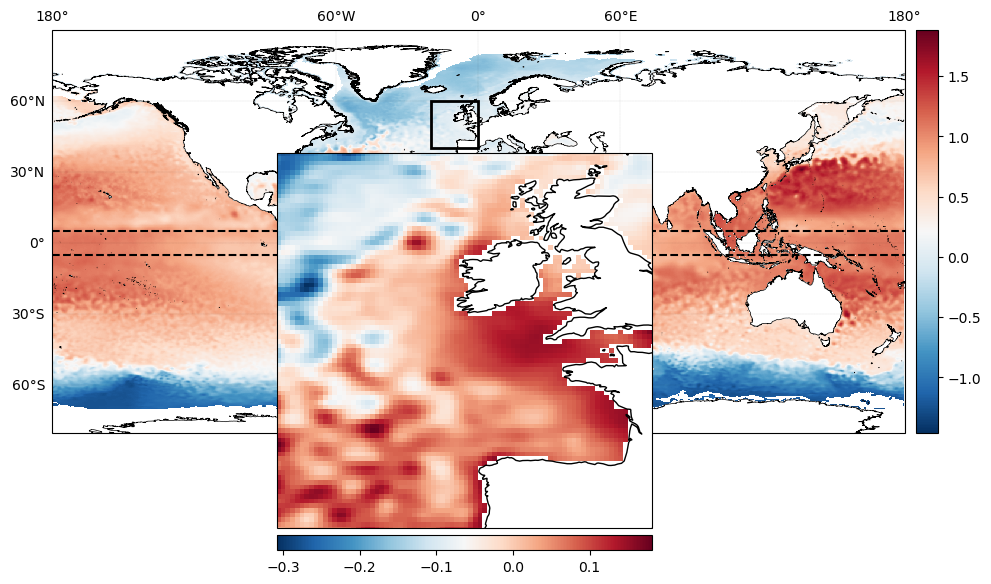

In [51]:
plot_map_zoom(ssh.adt[0],ssh.lon,ssh.lat)

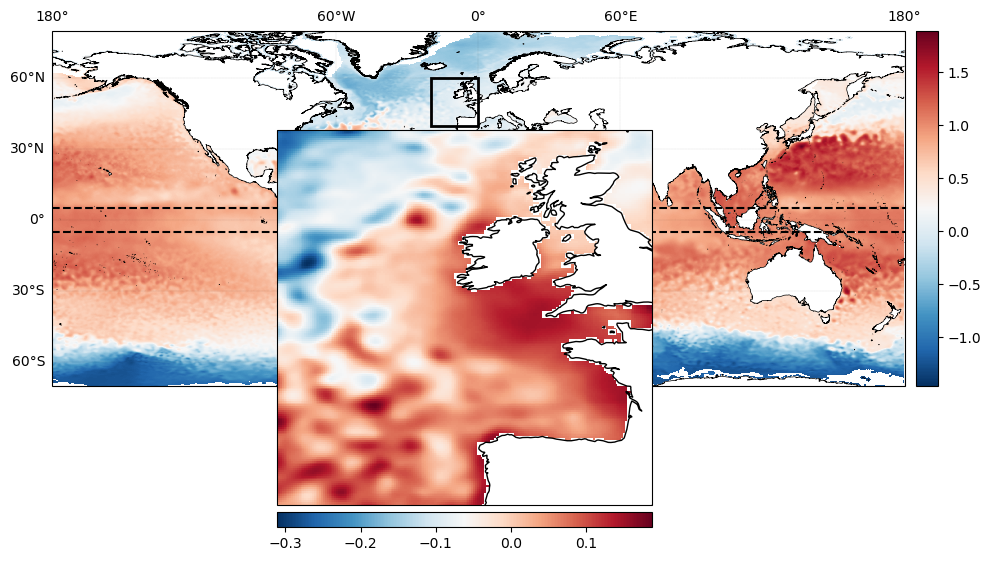

In [53]:
plot_map_zoom(maps.adt[0],maps.lon,maps.lat)